<a href="https://colab.research.google.com/github/SuphakitSA/WebApp_SkinLemon/blob/main/machine%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **resouce**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kittanate","key":"03e1c64d4bc19897f95c2ed312a57ea8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d haroonalam16/20-skin-diseases-dataset

 99% 317M/321M [00:11<00:00, 31.1MB/s]
100% 321M/321M [00:11<00:00, 28.8MB/s]


In [ ]:
!unzip /content/20-skin-diseases-dataset.zip -d /content

Archive:  /content/20-skin-diseases-dataset.zip
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07PerioralDermEye.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07Rhinophyma1.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07RosaceaFulFAce.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07RosaceaMilia0120.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07RosaceaOK0828063.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07SteroidPerioral.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07SteroidPerioral1.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07VascularFace0120.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07rhnophymas0321051.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/07sebDerem1101051.jpg  
  inflating: /content/Dataset/test/Acne and Rosacea Photos/08PerioralDerm1.jpg  
  inflating: /content/Dataset/test/Acne 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# **Data prepocess**

In [ ]:
# Define the path to your dataset directory
dataset_dir = "/content/Dataset/train"

In [ ]:
pip install git+https://github.com/ildoonet/pytorch-randaugment

  Cloning https://github.com/ildoonet/pytorch-randaugment to /tmp/pip-req-build-wq5ednz1
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-randaugment /tmp/pip-req-build-wq5ednz1
  Resolved https://github.com/ildoonet/pytorch-randaugment to commit 48b8f509c4bbda93bbe733d98b3fd052b6e4c8ae
  Preparing metadata (setup.py) ... done
  Created wheel for RandAugment: filename=RandAugment-0.1-py3-none-any.whl size=24195 sha256=c2886a0f5b7700606dd45f709ef06205157d6d491b732ace80264ba354246e79
  Stored in directory: /tmp/pip-ephem-wheel-cache-m67onaxd/wheels/e2/12/da/2e84ae65c614bbb6f82348ded40f0faccf5d46154216785bca
Successfully built RandAugment


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.utils import shuffle
from RandAugment import RandAugment

# Define dataset directory
dataset_dir = "/content/Dataset/train"
transform1 = transforms.Compose([
transforms.Resize((256, 256)),transforms.ToTensor()])
# Load original dataset
original_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform1)

# First, perform simple oversampling
def oversample(dataset):
    labels = torch.tensor(dataset.targets)
    unique, counts = torch.unique(labels, return_counts=True)
    max_count = torch.max(counts)
    oversampled_data = []

    for label in unique:
        indices = (labels == label).nonzero(as_tuple=True)[0]
        num_samples = max_count - len(indices)
        if num_samples > 0:
            oversampled_indices = torch.randint(low=0, high=len(indices), size=(num_samples,))
            oversampled_data.extend(indices[oversampled_indices])

    return torch.utils.data.Subset(dataset, oversampled_data)

# Create oversampled dataset
oversampled_dataset = oversample(original_dataset)
dataset = ImageFolder(root=dataset_dir, transform=transform1)
# Define data loader for oversampled training set
batch_size = 32
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])
transform.transforms.insert(0, RandAugment(3, 5))
oversampled_train_loader = DataLoader(oversampled_dataset, batch_size=batch_size, shuffle=True)
oversampled_train_loader.dataset.transform = transform

In [ ]:
for i,l in oversampled_train_loader:
  print(i.shape,l.shape)
  break

torch.Size([32, 3, 256, 256]) torch.Size([32])


In [ ]:
print(oversampled_train_loader)

In [ ]:
'''# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),           # Convert images to tensors
])
# Define the path to your dataset directory
dataset_dir = "/content/Dataset/train"
dataset = ImageFolder(root=dataset_dir, transform=transform)

# Now, 'dataset' contains all your image data automatically transformed into tensors.
# You can access the images and their corresponding labels using indexing, e.g.,
image_tensor, label = dataset[1162]  # Get the first image and its label

# Print the shape of the image tensor and the label
print("Image tensor shape:", image_tensor.shape)
print("Label:", label)'''

In [ ]:
# Define the size of the validation set as a percentage of the total dataset
validation_split = 0.1
dataset_size = len(dataset)
split = int(validation_split * dataset_size)

# Define indices for training and validation sets
indices = list(range(dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders for training and validation sets
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

# Get one batch of data
images, labels = next(iter(train_loader))

# Print shapes
print("Images batch shape:", images.shape)
print("Labels batch shape:", labels.shape)

Images batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


In [ ]:
'''# Define the path to your dataset directory
train_dir = "/content/drive/MyDrive/FinalPJ/Dataset/train"
test_dir = "/content/drive/MyDrive/FinalPJ/Dataset/test"'''

'# Define the path to your dataset directory\ntrain_dir = "/content/drive/MyDrive/FinalPJ/Dataset/train"\ntest_dir = "/content/drive/MyDrive/FinalPJ/Dataset/test"'

In [ ]:
image_tensor, label = train_data[1500]  #
print("Image tensor shape:", image_tensor.shape)
print("Label:", label)

NameError: name 'train_data' is not defined

In [ ]:
'''# Define the size of the validation set as a percentage of the total dataset
validation_split = 0.1
dataset_size = len(train_data)
split = int(validation_split * dataset_size)

# Define indices for training and validation sets
indices = list(range(dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)'''

# **Modelv1**

# model

In [ ]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class PyramidAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBnRelu(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()
        self.up = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
        self.conv = ConvBnRelu(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x1, x2):
        x1 = self.up(x1)  # Upsample
        return self.conv(x1 + x2)  # Combine features from skip connection and upsampled features

class Pylon(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        base_model = resnet50(pretrained=True)
        self.initial_conv = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool
        )

        self.encoder1 = base_model.layer1
        self.encoder2 = base_model.layer2
        self.encoder3 = base_model.layer3
        self.encoder4 = base_model.layer4

        self.pyramid_attention = PyramidAttention(in_channels=2048, out_channels=1024)
        self.up3 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up1 = UpSample(256, 64)

        # Add Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final classification layer
        self.classifier = nn.Linear(64, n_classes)  # Assuming '64' is the output channel count of the last UpSample

    def forward(self, x):
        x = self.initial_conv(x)
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x = self.pyramid_attention(x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)

        # Global Average Pooling before the classifier
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the features for the classifier
        x = self.classifier(x)

        return x
model = Pylon(19).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


# train

In [ ]:
# Define a loss function. For example, binary cross-entropy for binary classification
criterion = nn.CrossEntropyLoss()

# Choose an optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Move the model to the GPU if available

In [ ]:
from datetime import datetime
# Training loop v1 trained 50 first
num_epochs = 30
min_loss = float('inf')  # Initialize minimum loss to positive infinity
train_losses = []  # List to store training losses

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)

    epoch_loss = total_loss / len(dataset)*0.9
    train_losses.append(epoch_loss)  # Append epoch loss to train_losses list

    # Print the loss after each epoch
    timestamp = datetime.now()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Timestamp: {timestamp}')

    # Check if the current epoch loss is lower than the minimum loss
    if epoch_loss < min_loss:
        min_loss = epoch_loss
        # Save model weights
        torch.save(model.state_dict(), '/content/drive/MyDrive/4_ML/FinalPJ/Checkpoint/model_weights.pth')
        print("Model weights saved.")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

# test

In [ ]:
'''# Load the model weights onto the CPU
model.load_state_dict(torch.load('/content/drive/MyDrive/4_ML/FinalPJ/Checkpoint/model_weights.pth', map_location=torch.device('cpu')))'''

<All keys matched successfully>

In [ ]:
# Load the model weights onto the GPU
model.load_state_dict(torch.load('/content/drive/MyDrive/4_ML/FinalPJ/Checkpoint/model_weights.pth'))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Set the model to evaluation mode
model.eval()

true_labels = []
predicted_labels = []

# Iterate through the validation or test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Compute predicted labels
        _, predicted = torch.max(outputs, 1)

        # Collect true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print or return evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 1.0
Recall: 0.7269230769230769
F1 Score: 0.841870824053452


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**V2**

# model

In [ ]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class PyramidAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Pyramid attention layers with different kernel sizes
        self.conv1x1 = ConvBnRelu(in_channels, out_channels, kernel_size=1)
        self.conv3x3 = ConvBnRelu(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv5x5 = ConvBnRelu(in_channels, out_channels, kernel_size=5, padding=2)
        self.conv7x7 = ConvBnRelu(in_channels, out_channels, kernel_size=7, padding=3)

        # Fusion layer to combine the different scale features
        self.fusion_conv = ConvBnRelu(out_channels * 4, out_channels, kernel_size=1)

    def forward(self, x):
      # Apply pyramid convolutions
        conv1x1 = self.conv1x1(x)
        conv3x3 = self.conv3x3(x)
        conv5x5 = self.conv5x5(x)
        conv7x7 = self.conv7x7(x)

        # Concatenate along the channel dimension
        concatenated = torch.cat([conv1x1, conv3x3, conv5x5, conv7x7], dim=1)

        # Fuse concatenated features
        fused = self.fusion_conv(concatenated)
        return fused

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()
        self.up = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
        self.conv = ConvBnRelu(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x1, x2):
        x1 = self.up(x1)  # Upsample
        return self.conv(x1 + x2)  # Combine features from skip connection and upsampled features

class Pylon(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        base_model = resnet50(pretrained=True)
        self.initial_conv = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool
        )

        self.encoder1 = base_model.layer1
        self.encoder2 = base_model.layer2
        self.encoder3 = base_model.layer3
        self.encoder4 = base_model.layer4

        self.pyramid_attention = PyramidAttention(in_channels=2048, out_channels=1024)
        self.up3 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up1 = UpSample(256, 64)

        # Add Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final classification layer
        self.classifier = nn.Linear(64, n_classes)  # Assuming '64' is the output channel count of the last UpSample

    def forward(self, x):
        x = self.initial_conv(x)
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x = self.pyramid_attention(x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)

        # Global Average Pooling before the classifier
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the features for the classifier
        x = self.classifier(x)

        return x
model = Pylon(19).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# train

In [ ]:
# Define a loss function. For example, binary cross-entropy for binary classification
criterion = nn.CrossEntropyLoss()

# Choose an optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/30, Loss: 1.8691, Timestamp: 2024-04-16 08:58:22.598297
Model weights saved.
Epoch 2/30, Loss: 1.3747, Timestamp: 2024-04-16 08:59:02.599845
Model weights saved.
Epoch 3/30, Loss: 1.1651, Timestamp: 2024-04-16 08:59:42.567197
Model weights saved.
Epoch 4/30, Loss: 0.9723, Timestamp: 2024-04-16 09:00:22.805452
Model weights saved.
Epoch 5/30, Loss: 0.8438, Timestamp: 2024-04-16 09:01:03.594532
Model weights saved.
Epoch 6/30, Loss: 0.7623, Timestamp: 2024-04-16 09:01:43.843937
Model weights saved.
Epoch 7/30, Loss: 0.6426, Timestamp: 2024-04-16 09:02:24.774869
Model weights saved.
Epoch 8/30, Loss: 0.5880, Timestamp: 2024-04-16 09:03:04.946155
Model weights saved.
Epoch 9/30, Loss: 0.5220, Timestamp: 2024-04-16 09:03:45.274211
Model weights saved.
Epoch 10/30, Loss: 0.4546, Timestamp: 2024-04-16 09:04:25.402700
Model weights saved.
Epoch 11/30, Loss: 0.4394, Timestamp: 2024-04-16 09:05:05.874846
Model weights saved.
Epoch 12/30, Loss: 0.4175, Timestamp: 2024-04-16 09:05:46.14472

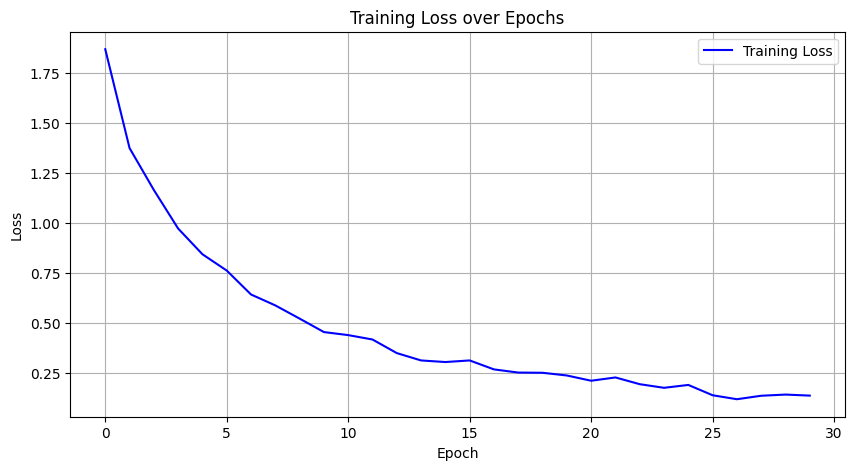

In [ ]:
from datetime import datetime
# Training loop v1 trained 50 last
num_epochs = 30
min_loss = float('inf')  # Initialize minimum loss to positive infinity
train_losses = []  # List to store training losses

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)

    epoch_loss = total_loss / len(dataset)*0.9
    train_losses.append(epoch_loss)  # Append epoch loss to train_losses list

    # Print the loss after each epoch
    timestamp = datetime.now()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Timestamp: {timestamp}')

    # Check if the current epoch loss is lower than the minimum loss
    if epoch_loss < min_loss:
        min_loss = epoch_loss
        # Save model weights
        #torch.save(model.state_dict(), '/content/drive/MyDrive/4_ML/FinalPJ/Checkpoint/modelV2_weights.pth')
        torch.save(model.state_dict(), '/content/modelV3_weights.pth')
        print("Model weights saved.")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# evaluation

In [ ]:
model.load_state_dict(torch.load('/content/modelV3_weights.pth'))

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/4_ML/FinalPJ/Checkpoint/modelV2_weights.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/4_ML/FinalPJ/Checkpoint/modelV2_weights.pth'))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Set the model to evaluation mode
model.eval()

true_labels = []
predicted_labels = []

# Iterate through the validation or test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Compute predicted labels
        _, predicted = torch.max(outputs, 1)

        # Collect true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print or return evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 1.0
Recall: 0.6576923076923077
F1 Score: 0.7935034802784223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **V3**

# define model

In [ ]:
class ConvBnRelu(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int = 1,
                 padding: int = 0,
                 dilation: int = 1,
                 groups: int = 1,
                 add_bn: bool = True,
                 add_relu: bool = True,
                 bias: bool = True,
                 interpolate: bool = False):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              dilation=dilation,
                              bias=bias,
                              groups=groups)
        self.add_relu = add_relu
        self.add_bn = add_bn
        self.interpolate = interpolate
        if add_bn:
            self.bn = nn.BatchNorm2d(out_channels)
        if add_relu:
            self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
      x = self.conv(x)
      if self.add_bn:
          x = self.bn(x)
      if self.add_relu:
          x = self.activation(x)
      if self.interpolate:
          x = F.interpolate(x,
                            scale_factor=2,
                            mode='bilinear',
                            align_corners=True)
      return x

class PyramidAttention(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        use_pa: bool = True,
        upscale_mode='bilinear',
        align_corners=True,
    ):
        super(PyramidAttention, self).__init__()

        self.upscale_mode = upscale_mode
        self.align_corners = align_corners if upscale_mode == 'bilinear' else None
        self.use_pa = use_pa

        # middle branch
        self.mid = nn.Sequential(
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ))

        # pyramid attention branch
        if use_pa:
            self.down1 = nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ConvBnRelu(in_channels=in_channels,
                           out_channels=1,
                           kernel_size=7,
                           stride=1,
                           padding=3))
            self.down2 = nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ConvBnRelu(in_channels=1,
                           out_channels=1,
                           kernel_size=5,
                           stride=1,
                           padding=2))
            self.down3 = nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ConvBnRelu(in_channels=1,
                           out_channels=1,
                           kernel_size=3,
                           stride=1,
                           padding=1))

            self.conv3 = ConvBnRelu(in_channels=1,
                                    out_channels=1,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1)
            self.conv2 = ConvBnRelu(in_channels=1,
                                    out_channels=1,
                                    kernel_size=5,
                                    stride=1,
                                    padding=2)
            self.conv1 = ConvBnRelu(in_channels=1,
                                    out_channels=1,
                                    kernel_size=7,
                                    stride=1,
                                    padding=3)

    def forward(self, x):
      upscale_parameters = dict(mode=self.upscale_mode,
                                  align_corners=self.align_corners)

      mid = self.mid(x)

      if self.use_pa:
          x1 = self.down1(x)
          x2 = self.down2(x1)
          x3 = self.down3(x2)
          x = F.interpolate(self.conv3(x3),
                            scale_factor=2,
                            **upscale_parameters)
          x = F.interpolate(self.conv2(x2) + x,
                            scale_factor=2,
                            **upscale_parameters)
          x = F.interpolate(self.conv1(x1) + x,
                            scale_factor=2,
                            **upscale_parameters)
          x = torch.mul(x, mid)
      else:
          x = mid
      return x

class UpSample(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        up_type: str = '2layer',
        kernel_size: int = 1,
        upscale_mode: str = 'bilinear',
        align_corners=True,
    ):
        super(UpSample, self).__init__()

        self.upscale_mode = upscale_mode
        self.align_corners = align_corners if upscale_mode == 'bilinear' else None

        self.conv = nn.Conv2d(in_channels= in_channels,
                              out_channels=128,
                              kernel_size=1,
                              )

        if up_type == '1layer':
            self.conv1 = ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
            )
        elif up_type == '2layer':
            self.conv1 = nn.Sequential(
                ConvBnRelu(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                ),
                ConvBnRelu(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                ),
            )
        else:
            raise NotImplementedError()

    def forward(self, x, y):
        """
        Args:
            x: low level feature
            y: high level feature
        """
        h, w = x.size(2), x.size(3)
        y_up = F.interpolate(y,
                             size=(h, w),
                             mode=self.upscale_mode,
                             align_corners=self.align_corners)
        conv = self.conv1(x)
        return y_up + conv

class Pylon(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        base_model = resnet50(pretrained=True)
        self.initial_conv = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool
        )

        self.encoder1 = base_model.layer1
        self.encoder2 = base_model.layer2
        self.encoder3 = base_model.layer3
        self.encoder4 = base_model.layer4

        self.conv3 = nn.Conv2d(in_channels= 1024,
                              out_channels=128,
                              kernel_size=1,
                              )

        self.conv2 = nn.Conv2d(in_channels= 512,
                              out_channels=128,
                              kernel_size=1,
                              )

        self.conv1 = nn.Conv2d(in_channels= 256,
                              out_channels=128,
                              kernel_size=1,
                              )

        self.pyramid_attention = PyramidAttention(in_channels=2048, out_channels=128)
        self.up3 = UpSample(in_channels=128,out_channels=128)
        self.up2 = UpSample(in_channels=128,out_channels=128)
        self.up1 = UpSample(in_channels=128,out_channels=128)

        # Add Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final classification layer
        self.classifier = nn.Linear(128, n_classes)  # Assuming '64' is the output channel count of the last UpSample

    def forward(self, x):
        x = self.initial_conv(x)
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)

        x3 = self.conv3(x3)
        x2 = self.conv2(x2)
        x1 = self.conv1(x1)

        x = self.pyramid_attention(x4)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)

        # Global Average Pooling before the classifier
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the features for the classifier
        x = self.classifier(x)

        return x
model = Pylon(19).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 306MB/s]


# train session

In [ ]:
# Define a loss function. For example, binary cross-entropy for binary classification
criterion = nn.CrossEntropyLoss()

# Choose an optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
from datetime import datetime
# Training loop v1 trained 50 last
num_epochs = 30
min_loss = float('inf')  # Initialize minimum loss to positive infinity
train_losses = []  # List to store training losses

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in oversampled_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)

    epoch_loss = total_loss / len(dataset)*0.9
    train_losses.append(epoch_loss)  # Append epoch loss to train_losses list

    # Print the loss after each epoch
    timestamp = datetime.now()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Timestamp: {timestamp}')

    # Check if the current epoch loss is lower than the minimum loss
    if epoch_loss < min_loss:
        min_loss = epoch_loss
        # Save model weights
        torch.save(model.state_dict(), '/content/drive/MyDrive/FinalPJ/Checkpoint/modelV3_weights_overaug.pth')
        #torch.save(model.state_dict(), '/content/modelV3_weights.pth')
        print("Model weights saved.")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('/content/modelV3_weights.pth'))

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/4_ML/FinalPJ/Checkpoint/modelV3_weights_overaug.pth')

# evaluation

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/FinalPJ/Checkpoint/modelV3_weights_overaug.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Set the model to evaluation mode
model.eval()

true_labels = []
predicted_labels = []

# Iterate through the validation or test dataset
with torch.no_grad():
    for inputs, labels in train_loader:
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Compute predicted labels
        _, predicted = torch.max(outputs, 1)

        # Collect true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print or return evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.5671884502707835
Recall: 0.7322264793529162
F1 Score: 0.6355109257329402


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Use case

## **Heatmap**

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [ ]:
model = Pylon(19)

In [ ]:
# Load the model weights onto the CPU
model.load_state_dict(torch.load('/content/drive/MyDrive/4_ML/FinalPJ/Checkpoint/modelV3_weights.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# Define the same transforms you used during training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

Enter URL: https://www.verywellhealth.com/thmb/-8t_chX-BYOhvDIL7Vf06wj4e14=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/melanoma-photo5-56a880843df78cf7729e66a9-51e5344044134af7af4f968a4eab8865.jpg
Predicted class: 13


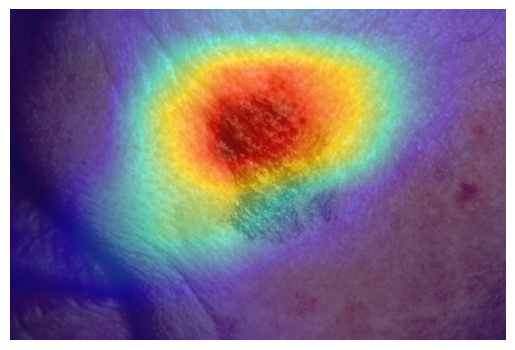

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def get_image_from_url(url):
    try:
        # Send a GET request to the URL to fetch the image
        response = requests.get(url)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Open the image using PIL
            image = Image.open(BytesIO(response.content))

            # You can perform any additional processing on the image if needed

            return image
        else:
            print("Failed to fetch image. Status code:", response.status_code)
            return None
    except Exception as e:
        print("Error fetching image:", e)
        return None

# Example usage
url = input("Enter URL: ")
image = get_image_from_url(url)

image_tensor = transform(image.convert('RGB')).unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to(device)

with torch.no_grad():  # No need to track gradients
    model.eval()
    output = model(image_tensor)
    predictions = output.argmax(dim=1).item()
    prediction = torch.argmax(output, 1)
    print(f'Predicted class: {prediction.item()}')

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Initialize GradCAM
target_layer = model.encoder4[-1]
#model.eval()
cam = GradCAM(model=model, target_layers=[target_layer])

targets = [ClassifierOutputTarget(predictions)]
grayscale_cam = cam(input_tensor=image_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch
grayscale_cam = grayscale_cam[0, :]

# Use the utility function to overlay the heatmap on the image
rgb_img = np.float32(image) / 255
heatmap_resized = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))
heatmap = show_cam_on_image(rgb_img, heatmap_resized, use_rgb=True)

# Display the original image with the heatmap
plt.imshow(heatmap)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
# Load your image
img_path = '/content/Dataset/test/Eczema Photos/03DermatitisLids1.jpg'
image = Image.open(img_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to(device)

In [ ]:
with torch.no_grad():  # No need to track gradients
    model.eval()
    output = model(image_tensor)
    predictions = output.argmax(dim=1).item()
    prediction = torch.argmax(output, 1)
    print(f'Predicted class: {prediction.item()}')

Predicted class: 0


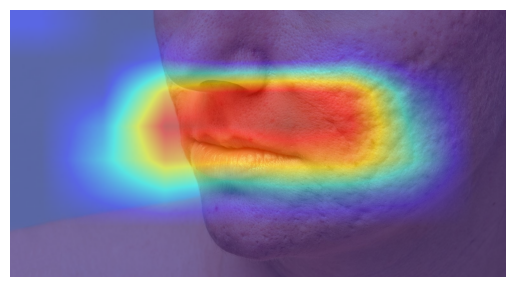

In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Initialize GradCAM
target_layer = model.encoder4[-1]
#model.eval()
cam = GradCAM(model=model, target_layers=[target_layer])

targets = [ClassifierOutputTarget(predictions)]
grayscale_cam = cam(input_tensor=image_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch
grayscale_cam = grayscale_cam[0, :]

# Use the utility function to overlay the heatmap on the image
rgb_img = np.float32(image) / 255
heatmap_resized = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))
heatmap = show_cam_on_image(rgb_img, heatmap_resized, use_rgb=True)

# Display the original image with the heatmap
plt.imshow(heatmap)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()